In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input
from keras import regularizers
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from keras.layers.normalization import BatchNormalization


from IPython import embed


def import_data(dataset="data"):
    X = []
    Y = []

    f=open(dataset, 'r')
    for line in f.readlines():
        intLine = [int(s) for s in line.split(' ')]
        X.append(intLine[:-1])
        Y.append(intLine[-1:])

    return X,Y

def create_dense_model(input_size):
    model = Sequential()

    if input_size % 2 == 0:
        model.add(Dense(int(input_size/2 + 1), kernel_initializer=keras.initializers.lecun_uniform(seed=None), input_shape=(input_size,)))
    else:
        model.add(Dense(int((input_size+1)/2), kernel_initializer=keras.initializers.lecun_uniform(seed=None), input_shape=(input_size,)))
    
    
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    
    
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), metrics=['binary_crossentropy', 'accuracy'])
    return model

def draw_figure(data, label, fig=None, ax=None):
    # Plot the change in the validation set vs change in the training set
    if not fig:
        fig = plt.figure(figsize=(6, 4))
    if not ax:
        ax = fig.add_subplot(111)
    
    
    real_data = []
    scale = int(len(data[0])/50)
    
    
    
    for i in range(0, 50):
        real_data.append(data[0][i*scale])
    
    ax.plot(np.arange(1, len(data[0]) + 1, scale), real_data, label=label)
    ax.legend(loc='best')
    ax.set_xlabel('Epoch number')
    return fig, ax

Using TensorFlow backend.



Training examples: 80000
Test examples: 20000
Epochs: 2000  -------  Try: 0
20000/20000 [==============================] - 0s 9us/step


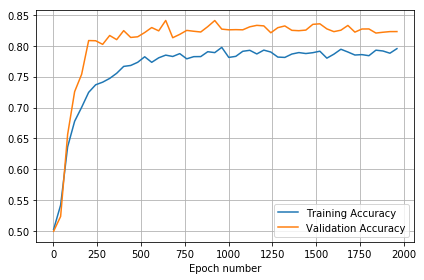

[[7496 1027]
 [2485 8992]]

Validation Avg: [ 0.8244]
Train Avg: [ 0.7895625]


[0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1]    [0]
[0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 1]    [1]
[0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0]    [0]
[1 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1]    [0]
[1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0]    [0]
[1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1]    [0]
[1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0]    [0]
[0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1]    [0]
[0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1]    [0]
[0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1]    [0]
[1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1]    [0]



Epochs: 2000  -------  Try: 1


In [ ]:
test_size = 0.2
epochs = [2000]
b_size = 100
tries = 3
exp = 'idk'


histories = np.array([])

X, Y = import_data()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print("\nTraining examples: " +  str(X_train.shape[0]))
print("Test examples: " +  str(X_test.shape[0]))

for ep in epochs:
    avg_val = np.array([])
    avg_train = np.array([])
    for t in range(tries):
        print("Epochs: " + str(ep) + '  -------  Try: ' + str(t))
        classifier = create_dense_model(len(X_train[0]))
        #classifier.summary()

        history = classifier.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=ep, batch_size=b_size, verbose=0)
        result = classifier.evaluate(X_test, Y_test, batch_size=b_size)

        avg_val = np.append(avg_val, result[2])
        avg_train = np.append(avg_train, history.history['acc'][-1])
        histories = np.append(histories, history)
        
        val_acc = history.history['val_acc']
        train_acc = history.history['acc']
        
        with open(exp + '/acc_' + str(len(X_train[0])) + '_' + str(ep) + '_' + str(t) +'.txt', "w") as file:
            file.write('val_acc  ' + str(val_acc))
            file.write('\ntrain_acc  ' + str(train_acc))

        fig, ax = draw_figure([train_acc], 'Training Accuracy')
        fig, ax = draw_figure([val_acc], 'Validation Accuracy', fig, ax)

        ax.grid('on')
        fig.tight_layout() 
        fig.savefig(exp + '/graph_' + str(len(X_train[0])) + '_' + str(ep) + '_' + str(t) + '.pdf')
        plt.show() 

        

        print(confusion_matrix(classifier.predict(X_test)>0.5, Y_test))

        print("\nValidation Avg: " + str(avg_val))
        print("Train Avg: " + str(avg_train))
        print("\n")

        c = 0
        classifications = (classifier.predict(X_test) > 0.5 ) == Y_test
        for i, flag in enumerate(classifications):
            if(flag == False and c<=10):
                print(str(X_test[i]) + "    " + str(Y_test[i]))
                c += 1
        
        c = 0
        with open(exp + '/data_' + str(len(X_train[0])) + '_' + str(ep) + '_' + str(t) + '.txt', "w") as file:
            file.write(str(confusion_matrix(classifier.predict(X_test)>0.5, Y_test)))
            
            file.write("\nValidation Avg: " + str(np.average(avg_val)))
            file.write("\nTrain Avg: " + str(np.average(avg_train)))
            file.write("\n\n")
            
            for i, flag in enumerate(classifications):
                if(flag == False and c<=10):
                    file.write('\n' + str(X_test[i]) + "    " + str(Y_test[i]))
                    c += 1
            

        print("\n\n")
    print("\n Overall for: " + str(len(X_train[0])) + '_' + str(ep))
    print(avg_val)
    print(avg_train)
    print("\nOVERALL VAL: " + str(np.average(avg_val)))
    print("OVERALL TRAIN: " + str(np.average(avg_train)))
    print("\n")
    
    with open(exp + '/data_' + str(len(X_train[0])) + '_' + str(ep) + '.txt', "w") as file:
        file.write(str(avg_val))
        file.write("\n" + str(avg_train))
        file.write("\n\nOVERALL VAL: " + str(np.average(avg_val)))
        file.write("\nOVERALL TRAIN: " + str(np.average(avg_train)))

In [3]:
from keras.utils import plot_model
plot_model(classifier, to_file='model.pdf', show_shapes=True, show_layer_names=False)

